In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder
from datasets import load_metric

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

# Set the batch size
batch_size = 60

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


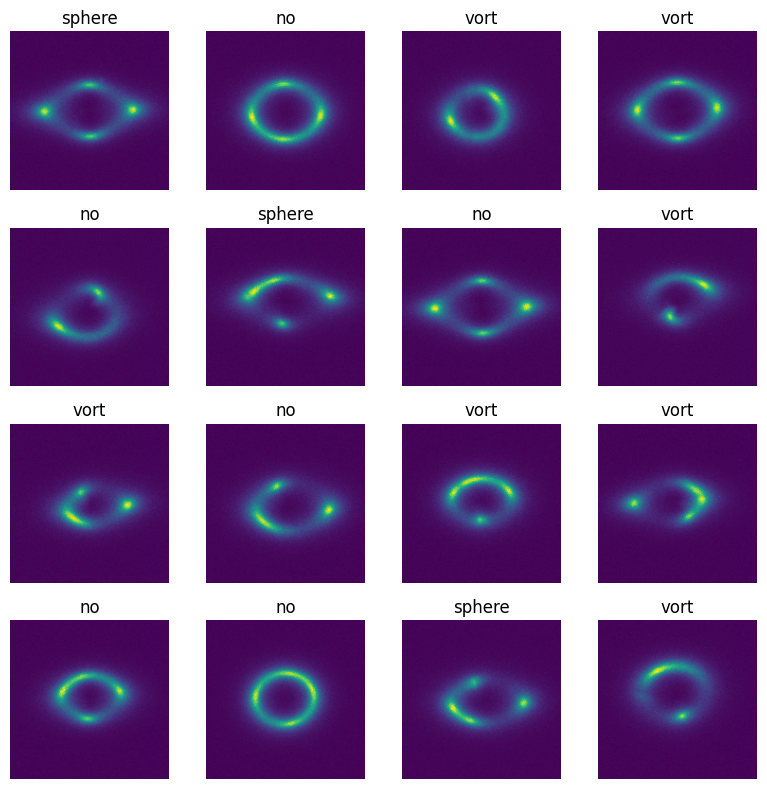

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [6]:
from transformers import CvtForImageClassification, CvtConfig

config = CvtConfig()
config.num_labels = 3
config.image_size = 150
config.num_channels = 1
config.id2label = {'0': 'no', '1': 'sphere', '2': 'vort'}
config.label2id = {'no': 0, 'sphere': 1, 'vort': 2}
config.depth = [1, 2, 4]
config.embed_dim = [32, 96, 192]
model = CvtForImageClassification(config)
model.to(device)

configuration = model.config
print(configuration)
model

CvtConfig {
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    4
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    32,
    96,
    192
  ],
  "id2label": {
    "0": "no",
    "1": "sphere",
    "2": "vort"
  },
  "image_size": 150,
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "label2id": {
    "no": 0,
    "sphere": 1,
    "vort": 2
  },
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 1,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
   

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                      (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=60,
    per_device_eval_batch_size=60,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Define the compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return load_metric("accuracy").compute(predictions=predictions, references=labels)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dict(train_dataset),
    eval_dataset=dict(val_dataset),
    compute_metrics=compute_metrics
)

In [ ]:
# Train the model
trainer.train()